# Combined  Model (XGBoost Oversampling + XGBoost Regression)

We developed a hybrid model using both xgboost regression and xgboost classification(while oversampling technique was implemented to enhance its performance). Subsequently, we evaluated the performance of this combined model on the test dataset while train_test_split is done based on typhoons' time and compared it with the result of the simple xgboost regression model. 

In [1]:
%load_ext jupyter_black

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shap
import imblearn
import statsmodels.api as sm
import statistics
import warnings

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBClassifier
from collections import Counter
from sty import fg, rs

from sklearn.metrics import confusion_matrix
from matplotlib import cm
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from utils import get_training_dataset

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
# Hide all warnings
warnings.filterwarnings("ignore")

In [4]:
# Read CSV file and import to a df
df = get_training_dataset()

In [5]:
for i in range(len(df)):
    df.at[i, "typhoon_year"] = str(df.loc[i]["typhoon_year"])

In [6]:
df["typhoon_name"] = df["typhoon_name"] + df["typhoon_year"]

In [7]:
# Replace empty cells of RWI with mean value
df["rwi"].fillna(df["rwi"].mean(), inplace=True)

# Set any values >100% to 100%,
for r in range(len(df)):
    if df.loc[r, "percent_houses_damaged"] > 100:
        df.at[r, "percent_houses_damaged"] = float(100)

In [8]:
df = (df[(df[["wind_speed"]] != 0).any(axis=1)]).reset_index(drop=True)
df = df.drop(columns=["grid_point_id", "typhoon_year"])

In [9]:
# Specify features
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    # "strong_roof_strong_wall",
    # "strong_roof_light_wall",
    # "strong_roof_salvage_wall",
    # "light_roof_strong_wall",
    # "light_roof_light_wall",
    # "light_roof_salvage_wall",
    # "salvaged_roof_strong_wall",
    # "salvaged_roof_light_wall",
    # "salvaged_roof_salvage_wall",
    "mean_slope",
    "std_slope",
    "mean_tri",
    "std_tri",
    "mean_elev",
    "coast_length",
    "with_coast",
    "urban",
    "rural",
    "water",
    "total_pop",
    "percent_houses_damaged_5years",
]

In [10]:
# df.loc[df['typhoon_name'] == 'GONI2020']

In [11]:
# List of typhoons
typhoons = [
    "DURIAN2006",
    "FENGSHEN2008",
    "KETSANA2009",
    "CONSON2010",
    "NESAT2011",
    "BOPHA2012",
    "NARI2013",
    "KROSA2013",
    "HAIYAN2013",
    "USAGI2013",
    "UTOR2013",
    "JANGMI2014",
    "KALMAEGI2014",
    "RAMMASUN2014",
    "HAGUPIT2014",
    "FUNG-WONG2014",
    "LINGLING2014",
    "MUJIGAE2015",
    "MELOR2015",
    "NOUL2015",
    "GONI2015",
    "LINFA2015",
    "KOPPU2015",
    "MEKKHALA2015",
    "HAIMA2016",
    "TOKAGE2016",
    "MERANTI2016",
    "NOCK-TEN2016",
    "SARIKA2016",
    "MANGKHUT2018",
    "YUTU2018",
    "KAMMURI2019",
    "NAKRI2019",
    "PHANFONE2019",
    "SAUDEL2020",
    "GONI2020",
    "VAMCO2020",
    "VONGFONG2020",
    "MOLAVE2020",
]

In [12]:
# Define bins
bins2 = [0, 0.00009, 1, 10, 50, 101]
bins_eval = [0, 1, 10, 20, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)

In [13]:
# Define range of for loop
# Latest typhoons in terms of time
num_exp = 12
typhoons_for_test = typhoons[-num_exp:]

# Define number of bins
num_bins = len(bins_eval)

In [14]:
# Define empty list to save RMSE in combined model

test_RMSE_lst = []
test_RMSE_bin = defaultdict(list)

# Define empty list to save RMSE in model1

test_RMSE_lst_M1 = []
test_RMSE_bin_M1 = defaultdict(list)

In [21]:
for run_ix in range(num_exp):

    # Oldest typhoons in the training set
    typhoons_train_lst = typhoons[run_ix : run_ix + 27]
    # print(typhoons_train_lst)

    bin_index2 = np.digitize(df["percent_houses_damaged"], bins=binsP2)
    y_input_strat = bin_index2

    # Split X and y from dataframe features
    X = df[features]
    y = df["percent_houses_damaged"]

    # Split df to train and test (one typhoon for test and the rest of typhoons for train)
    df_test = df[df["typhoon_name"] == typhoons_for_test[run_ix]]

    df_train = pd.DataFrame()
    for run_ix_train in range(len(typhoons_train_lst)):
        df_train = df_train.append(
            df[df["typhoon_name"] == typhoons_train_lst[run_ix_train]]
        )

    # Split X and y from dataframe features
    X_test = df_test[features]
    X_train = df_train[features]

    y_train = df_train["percent_houses_damaged"]
    y_test = df_test["percent_houses_damaged"]

    print(df_test["typhoon_name"].unique())

    # XGBoost Reduced Overfitting
    xgb = XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        colsample_bylevel=0.8,
        colsample_bynode=0.8,
        colsample_bytree=0.8,
        gamma=3,
        eta=0.01,
        importance_type="gain",
        learning_rate=0.1,
        max_delta_step=0,
        max_depth=4,
        min_child_weight=1,
        missing=1,
        n_estimators=100,
        early_stopping_rounds=10,
        n_jobs=1,
        nthread=None,
        objective="reg:squarederror",
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        seed=None,
        silent=None,
        subsample=0.8,
        verbosity=0,
        eval_metric=["rmse", "logloss"],
        random_state=0,
    )

    eval_set = [(X_train, y_train)]
    xgb_model = xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

    # Make prediction on train and test data
    y_pred_train = xgb.predict(X_train)
    y_pred = xgb.predict(X_test)

    # Calculate RMSE in total
    mse_train_idx = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train_idx)

    mse_idx = mean_squared_error(y_test, y_pred)
    rmseM1 = np.sqrt(mse_idx)

    # Add total RMSE of Model1 to the list
    test_RMSE_lst_M1.insert(run_ix, rmseM1)
    print("RMSE in total and per bin (M1 model)")
    print(f"total: {rmseM1:.2f}")

    # Calculate RMSE per bins
    bin_index_test = np.digitize(y_test, bins=bins_eval)
    RSME_test_model1 = np.zeros(num_bins - 1)

    for bin_num in range(1, num_bins):

        # Estimation of RMSE for test data
        if (
            len(y_test[bin_index_test == bin_num]) != 0
            and len(y_pred[bin_index_test == bin_num]) != 0
        ):
            mse_idx = mean_squared_error(
                y_test[bin_index_test == bin_num], y_pred[bin_index_test == bin_num]
            )
            RSME_test_model1[bin_num - 1] = np.sqrt(mse_idx)

            # Add RMSE of Model1 to the list of each bin
            test_RMSE_bin_M1[bin_num].append(RSME_test_model1[bin_num - 1])
            print(f"bin{[bin_num]}:{RSME_test_model1[bin_num-1]}")
    # else:
    #    test_RMSE_bin_M1[bin_num].insert(run_ix, "No exist")

    # Define a threshold to separate target into damaged and not_damaged
    thres = 10.0
    y_test_bool = y_test >= thres
    y_train_bool = y_train >= thres
    y_test_bin = (y_test_bool) * 1
    y_train_bin = (y_train_bool) * 1

    sum(y_train_bin)

    # Define oversampling strategy
    over = RandomOverSampler(sampling_strategy=0.4)
    
    # Fit and apply the transform
    X_train_us, y_train_us = over.fit_resample(X_train, y_train_bin)
    print(Counter(y_train_bin))
    print(Counter(y_train_us))

    # Use XGBClassifier as a Machine Learning model to fit the data
    xgb_model = XGBClassifier(eval_metric=["error", "logloss"])

    eval_set = [(X_train, y_train_bin)]
    xgb_model.fit(
        X_train_us,
        y_train_us,
        eval_set=eval_set,
        verbose=False,
    )

    # Make prediction on test data and print Confusion Matrix
    y_pred_test = xgb_model.predict(X_test)
    cm_test = confusion_matrix(y_test_bin, y_pred_test)
    print(cm_test)

    # Make prediction on train data and print Confusion Matrix
    y_pred_train = xgb_model.predict(X_train)
    cm_train = confusion_matrix(y_train_bin, y_pred_train)
    print(cm_train)

    y_pred_train_us = xgb_model.predict(X_train_us)
    cm_train_us = confusion_matrix(y_train_us, y_pred_train_us)
    print(cm_train_us)

    reduced_df = X_train.copy()

    reduced_df["percent_houses_damaged"] = y_train.values
    reduced_df["predicted_value"] = y_pred_train

    fliterd_df = reduced_df[reduced_df.predicted_value == 1]

    ### Third step is to train XGBoost regression model for this reduced train data (including damg>10.0%)
    bin_index2 = np.digitize(fliterd_df["percent_houses_damaged"], bins=binsP2)
    y_input_strat = bin_index2

    # Split X and y from dataframe features
    X_r = fliterd_df[features]
    y_r = fliterd_df["percent_houses_damaged"]

    # XGBoost Reduced Overfitting
    xgbR = XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        colsample_bylevel=0.8,
        colsample_bynode=0.8,
        colsample_bytree=0.8,
        gamma=3,
        eta=0.01,
        importance_type="gain",
        learning_rate=0.1,
        max_delta_step=0,
        max_depth=4,
        min_child_weight=1,
        missing=1,
        n_estimators=100,
        early_stopping_rounds=10,
        n_jobs=1,
        nthread=None,
        objective="reg:squarederror",
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        seed=None,
        silent=None,
        subsample=0.8,
        verbosity=0,
        eval_metric=["rmse", "logloss"],
        random_state=0,
    )

    eval_set = [(X_r, y_r)]
    xgbR_model = xgbR.fit(X_r, y_r, eval_set=eval_set, verbose=False)

    # Make prediction on train and global test data
    y_pred_r = xgbR.predict(X_r)
    y_pred_test_total = xgbR.predict(X_test)

    # Calculate RMSE in total

    mse_train_idxR = mean_squared_error(y_r, y_pred_r)
    rmse_trainR = np.sqrt(mse_train_idxR)

    mse_idxR = mean_squared_error(y_test, y_pred_test_total)
    rmseR = np.sqrt(mse_idxR)

    ## Last step is to add model combination (model M1 with model MR)
    # Check the result of classifier for test set
    reduced_test_df = X_test.copy()

    # joined X_test with countinous target and binary predicted values
    reduced_test_df["percent_houses_damaged"] = y_test.values
    reduced_test_df["predicted_value"] = y_pred_test

    # damaged prediction
    fliterd_test_df1 = reduced_test_df[reduced_test_df.predicted_value == 1]

    # not damaged prediction
    fliterd_test_df0 = reduced_test_df[reduced_test_df.predicted_value == 0]

    # Use X0 and X1 for the M1 and MR models' predictions
    X1 = fliterd_test_df1[features]
    X0 = fliterd_test_df0[features]

    # For the output equal to 1 apply MR to evaluate the performance
    y1_pred = xgbR.predict(X1)
    y1 = fliterd_test_df1["percent_houses_damaged"]

    # For the output equal to 0 apply M1 to evaluate the performance
    y0_pred = xgb.predict(X0)
    y0 = fliterd_test_df0["percent_houses_damaged"]

    fliterd_test_df0["predicted_percent_damage"] = y0_pred
    if len(y1_pred) > 0:
        fliterd_test_df1["predicted_percent_damage"] = y1_pred

    # Join two dataframes together
    join_test_dfs = pd.concat([fliterd_test_df0, fliterd_test_df1])

    # Calculate RMSE in total
    mse_combined_model = mean_squared_error(
        join_test_dfs["percent_houses_damaged"],
        join_test_dfs["predicted_percent_damage"],
    )

    rmse_combined_model = np.sqrt(mse_combined_model)
    test_RMSE_lst.insert(run_ix, rmse_combined_model)
    print("RMSE in total and per bin (Combined model)")
    print(f"total: {rmse_combined_model:.2f}")

    # Calculate RMSE per bin
    y_join = join_test_dfs["percent_houses_damaged"]
    y_pred_join = join_test_dfs["predicted_percent_damage"]

    bin_index_test = np.digitize(y_join, bins=bins_eval)
    RSME_combined_model = np.zeros(num_bins - 1)

    for bin_num in range(1, num_bins):
        if (
            len(y_join[bin_index_test == bin_num]) != 0
            and len(y_pred_join[bin_index_test == bin_num]) != 0
        ):
            mse_combined_model_bin = mean_squared_error(
                y_join[bin_index_test == bin_num],
                y_pred_join[bin_index_test == bin_num],
            )
            RSME_combined_model[bin_num - 1] = np.sqrt(mse_combined_model_bin)
            test_RMSE_bin[bin_num].append(RSME_combined_model[bin_num - 1])
            print(f"bin{[bin_num]}: {RSME_combined_model[bin_num - 1]}")

        # else:
        #   test_RMSE_bin[bin_num].insert(run_ix, "No exist")

['NOCK-TEN2016']
RMSE in total and per bin (M1 model)
total: 5.38
bin[1]:2.3482560842041376
bin[2]:14.486276671473416
bin[3]:17.299815500972798
bin[4]:13.516810964137715
bin[5]:13.721287123012859
Counter({0: 33304, 1: 795})
Counter({0: 33304, 1: 13321})
[[1392   42]
 [  12   53]]
[[33303     1]
 [    0   795]]
[[33303     1]
 [    0 13321]]
RMSE in total and per bin (Combined model)
total: 7.04
bin[1]: 3.4478481137391035
bin[2]: 17.705918842849787
bin[3]: 23.70961494728222
bin[4]: 15.09920412439789
bin[5]: 10.439639390061952
['SARIKA2016']
RMSE in total and per bin (M1 model)
total: 0.42
bin[1]:0.4199770870355288
Counter({0: 33407, 1: 752})
Counter({0: 33407, 1: 13362})
[[1495]]
[[33403     4]
 [    0   752]]
[[33403     4]
 [    0 13362]]
RMSE in total and per bin (Combined model)
total: 0.42
bin[1]: 0.4199770870355288
['MANGKHUT2018']
RMSE in total and per bin (M1 model)
total: 8.07
bin[1]:1.0539302874074294
bin[2]:13.425444269856524
bin[3]:24.093734523582786
Counter({0: 32575, 1: 71

In [22]:
# Compare total RMSEs of Combined model with M1 model
combined_test_rmse = statistics.mean(test_RMSE_lst)
m1_test_rmse = statistics.mean(test_RMSE_lst_M1)

print(f"mean_RMSE_test_M1_model: {m1_test_rmse:.2f}")
print(f"mean_RMSE_test_Combined_model: {combined_test_rmse:.2f}")

mean_RMSE_test_M1_model: 2.32
mean_RMSE_test_Combined_model: 2.87


In [23]:
# Compare RMSE per bin between Combined model with M1 model

for bin_num in range(1, 6):
    combined_test_rmse_bin = statistics.mean(test_RMSE_bin[bin_num])
    m1_test_rmse_bin = statistics.mean(test_RMSE_bin_M1[bin_num])

    print(f"RMSE per bin {bin_num}")
    print(f"mean_RMSE_test_Combined_model: {combined_test_rmse_bin:.2f}")
    print(f"mean_RMSE_test_M1_model: {m1_test_rmse_bin:.2f}\n")

RMSE per bin 1
mean_RMSE_test_Combined_model: 1.12
mean_RMSE_test_M1_model: 0.79

RMSE per bin 2
mean_RMSE_test_Combined_model: 7.00
mean_RMSE_test_M1_model: 5.51

RMSE per bin 3
mean_RMSE_test_Combined_model: 15.43
mean_RMSE_test_M1_model: 13.68

RMSE per bin 4
mean_RMSE_test_Combined_model: 20.63
mean_RMSE_test_M1_model: 20.10

RMSE per bin 5
mean_RMSE_test_Combined_model: 35.10
mean_RMSE_test_M1_model: 35.31



In [24]:
# Define a function to plot RMSEs
def rmse_bin_plot(M1_rmse, combined_rmse, min_rg, max_rg, step):

    m1_test_rmse = statistics.mean(M1_rmse)
    plt.figure(figsize=(4, 3))
    plt.axvline(m1_test_rmse, color="b", linestyle="dashed")
    plt.hist(
        M1_rmse,
        bins=np.arange(min_rg, max_rg, step),
        edgecolor="k",
        histtype="bar",
        density=True,
    )
    m1_sd_test_rmse = statistics.stdev(M1_rmse)

    combined_test_rmse = statistics.mean(combined_rmse)
    plt.axvline(combined_test_rmse, color="red", linestyle="dashed")
    plt.hist(
        combined_rmse,
        bins=np.arange(min_rg, max_rg, step),
        color="orange",
        edgecolor="k",
        histtype="bar",
        density=True,
        alpha=0.7,
    )
    combined_sd_test_rmse = statistics.stdev(combined_rmse)

    print(f"mean_RMSE_M1: {m1_test_rmse:.2f}(±{m1_sd_test_rmse:.2f})")
    print(f"mean_RMSE_Combined: {combined_test_rmse:.2f}(±{combined_sd_test_rmse:.2f})")

    # create legend
    labels = ["Mean_M1", "Mean_combined", "M1", "Combined"]
    plt.legend(labels)

    plt.xlabel("The RMSE error")
    plt.ylabel("Frequency")
    plt.title("histogram of the RMSE distribution")
    plt.show()

RMSE and Stdev in total
mean_RMSE_M1: 2.32(±2.38)
mean_RMSE_Combined: 2.87(±3.07)


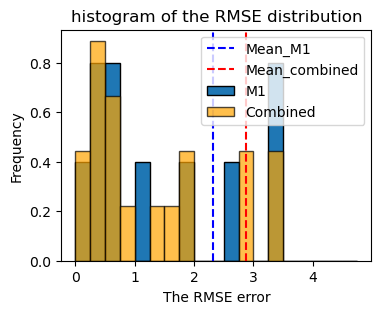

In [25]:
print("RMSE and Stdev in total")
rmse_bin_plot(test_RMSE_lst_M1, test_RMSE_lst, 0, 5, 0.25)

RMSE and Stdev per bin 1
mean_RMSE_M1: 0.79(±0.67)
mean_RMSE_Combined: 1.12(±1.17)


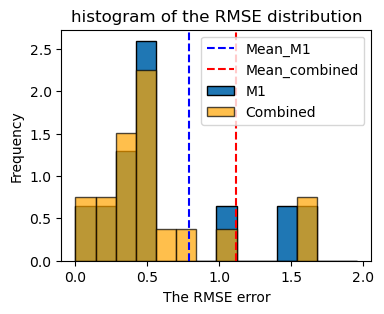

RMSE and Stdev per bin 2
mean_RMSE_M1: 5.51(±4.75)
mean_RMSE_Combined: 7.00(±6.21)


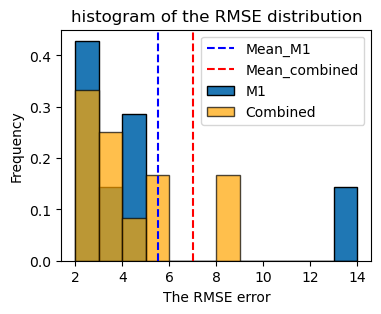

RMSE and Stdev per bin 3
mean_RMSE_M1: 13.68(±5.21)
mean_RMSE_Combined: 15.43(±6.75)


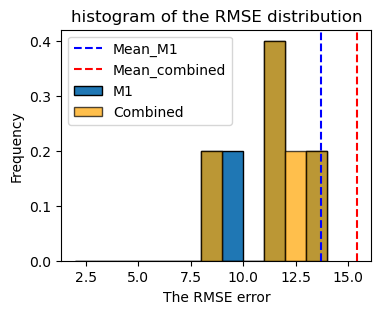

RMSE and Stdev per bin 4
mean_RMSE_M1: 20.10(±4.39)
mean_RMSE_Combined: 20.63(±3.60)


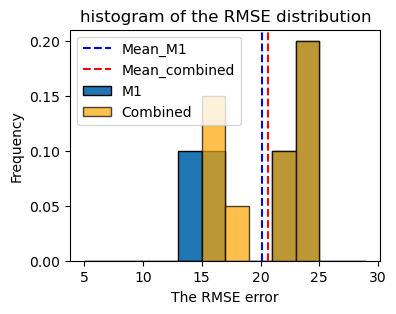

RMSE and Stdev per bin 5
mean_RMSE_M1: 35.31(±24.93)
mean_RMSE_Combined: 35.10(±25.28)


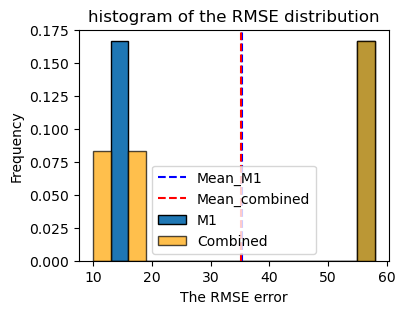

In [26]:
bin_params = {
    1: (0.0, 2.0, 0.14),
    2: (2, 15, 1),
    3: (2, 15, 1),
    4: (5, 30, 2),
    5: (10, 60, 3),
}

for bin_num in range(1, 6):

    print(f"RMSE and Stdev per bin {bin_num}")
    rmse_bin_plot(
        test_RMSE_bin_M1[bin_num], test_RMSE_bin[bin_num], *bin_params[bin_num]
    )